# Previsión de la demanda eléctrica española mediante modelos de aprendizaje automático supervisado

## Import Packages

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit

pd.options.display.max_columns=None
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['legend.loc'] = 'upper right'
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 15

import warnings
warnings.filterwarnings('ignore')

## Data Reading

In [3]:
df_weather = pd.read_csv(r'tmed_Espana_2011_2022.csv')
df_electricity = pd.read_csv(r'MW2011_2022.csv')
df_price = pd.read_csv(r'Price2011_2022.csv')
df_ibex35 = pd.read_csv(r'IBEX35_2011_2022.csv')

dataset = df_weather.merge(df_electricity, how='inner')
dataset = dataset.merge(df_price, how='inner')
dataset = dataset.merge(df_ibex35, how='inner')
dataset = dataset.rename(columns={'tmed_Nacional': 'Temperature', 'Price (EUR/MWhe)': 'Price', 'IBEX_med': 'IBEX35'})
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset = dataset.set_index('Date')
dataset

,Temperature,Demand,Price,IBEX35
Date,,,,
2011-01-01,9.6,605986.216,42.60,9928.25
2011-01-02,9.1,641856.087,42.73,9928.25
2011-01-03,6.5,801297.365,48.84,9922.05
2011-01-04,7.5,833253.263,45.67,9886.80
2011-01-05,10.0,803475.573,35.34,9740.85
...,...,...,...,...
2022-12-27,11.2,611568.630,107.66,8299.65
2022-12-28,10.3,629533.183,39.86,8285.85
2022-12-29,11.0,636823.461,16.24,8265.30


## Exploratory Data Analysis

In [4]:
dataset.describe()

,Temperature,Demand,Price,IBEX35
count,4383.000000,4383.000000,4383.000000,4383.000000
mean,15.822587,716678.865687,62.247372,9108.277299
std,6.217749,71601.697107,47.261686,1160.962146
min,1.400000,488999.626000,0.000000,6016.250000
25%,10.500000,668460.598000,41.845000,8342.500000
50%,15.300000,720216.639000,50.110000,9026.650000
75%,21.400000,767411.866500,60.720000,10064.700000
max,28.900000,925838.099000,547.460000,11822.700000


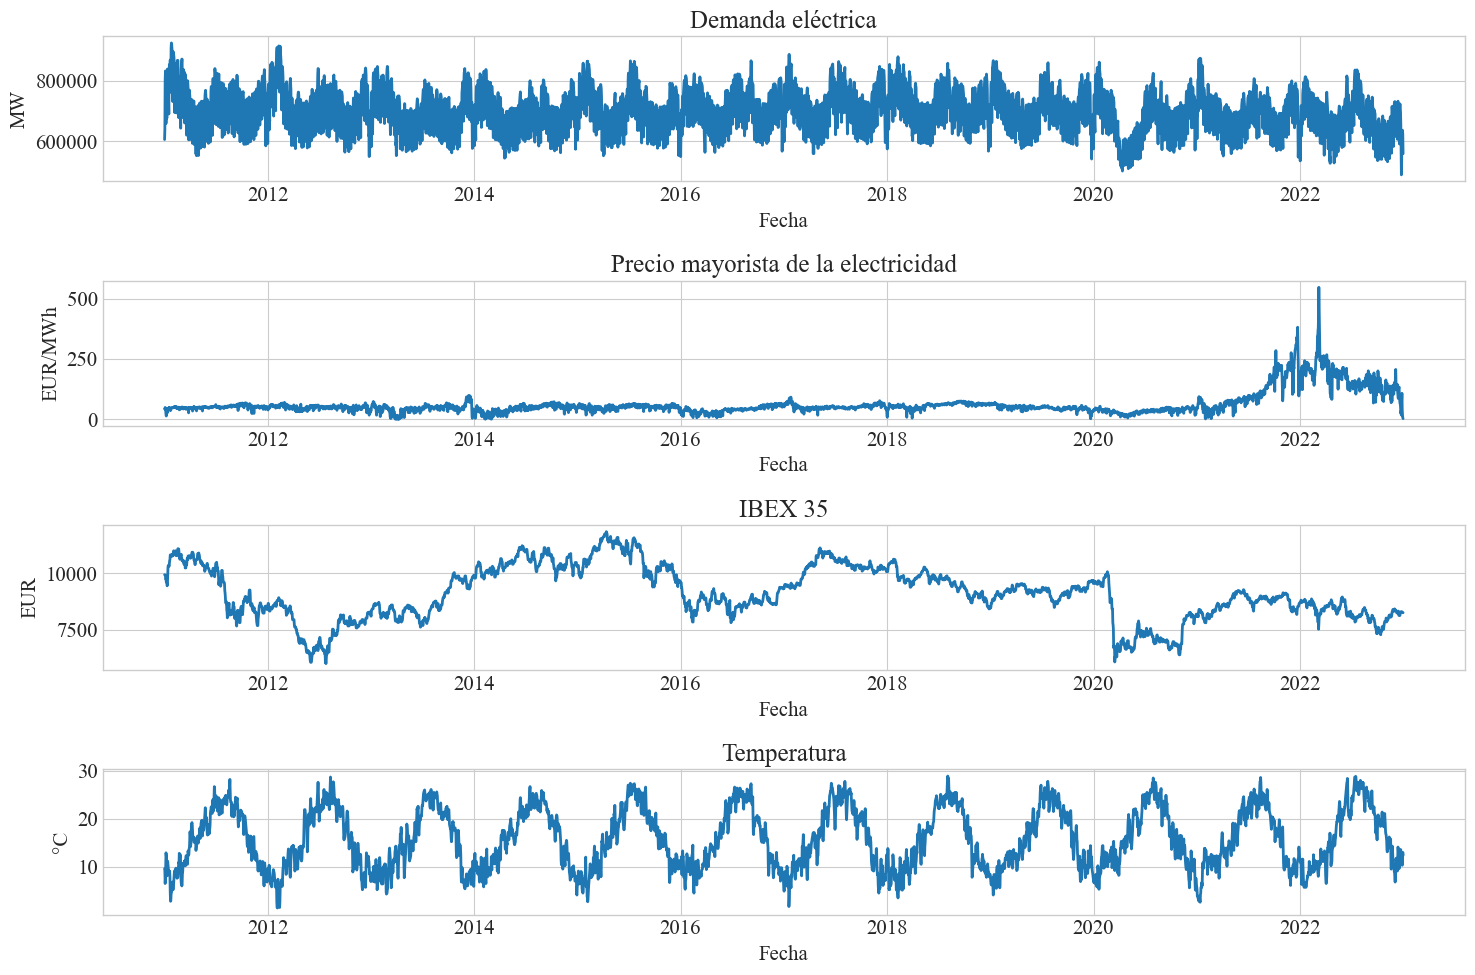

In [5]:
fig, axs = plt.subplots(4, figsize=(15,10), tight_layout=True)

axs[0].set_title('Demanda eléctrica')
axs[0].plot(dataset['Demand'], linewidth=2)
axs[0].set_xlabel('Fecha')
axs[0].set_ylabel('MW')
    

axs[1].set_title('Precio mayorista de la electricidad')
axs[1].plot(dataset['Price'], linewidth=2)
axs[1].set_xlabel('Fecha')
axs[1].set_ylabel('EUR/MWh')

axs[2].set_title('IBEX 35')
axs[2].plot(dataset['IBEX35'], linewidth=2)
axs[2].set_xlabel('Fecha')
axs[2].set_ylabel('EUR')

axs[3].set_title('Temperatura')
axs[3].plot(dataset['Temperature'], linewidth=2)
axs[3].set_xlabel('Fecha')
axs[3].set_ylabel('°C')

plt.show()

In [26]:
#Perform Dickey-Fuller test:
# H0: La serie NO es estacionaria 
# H1: La serie es estacionaria
# Por tanto, nos interesará que el contraste de hipótesis sea rechazado (p-valor < 0.05)

from statsmodels.tsa.stattools import adfuller

# Función para pasar el test de estacionariedad de Dickey Fuller
def test_stationarity(timeseries, cutoff = 0.05):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    pvalue = dftest[1]
    if pvalue <= cutoff:
        print('p-value = '+ str(pvalue) + ' The series '+ timeseries.name + ' is likely stationary.')
        #return True
    else:
        print('p-value = '+ str(pvalue) + ' The series '+ timeseries.name + ' is likely non-stationary.')
        #return False
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(dataset['Demand'])

Results of Dickey-Fuller Test:
p-value = 1.5814523230439722e-11 The series Demand is likely stationary.
Test Statistic                -7.672341e+00
p-value                        1.581452e-11
#Lags Used                     3.000000e+01
Number of Observations Used    4.352000e+03
Critical Value (1%)           -3.431853e+00
Critical Value (5%)           -2.862204e+00
Critical Value (10%)          -2.567124e+00
dtype: float64


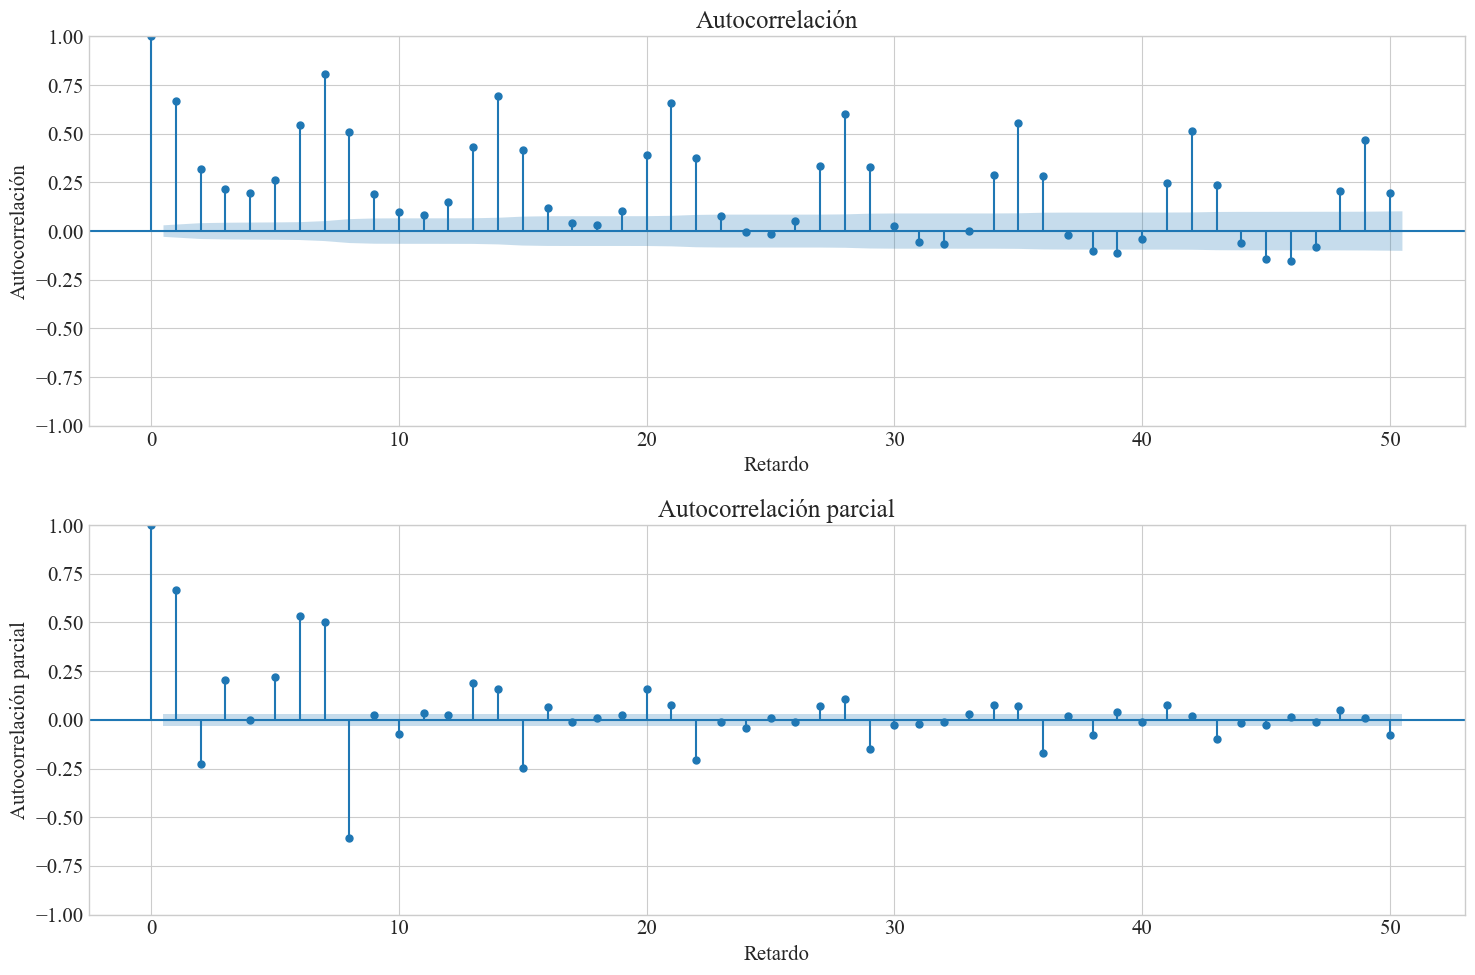

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Autocorrelaciones y autocorrelaciones parciales

# Draw Plot

fig, axes = plt.subplots(2,1, figsize=(15,10), tight_layout=True)

plot_acf(dataset['Demand'], lags=50, ax=axes[0])
axes[0].set_title('Autocorrelación')
axes[0].set_xlabel('Retardo')
axes[0].set_ylabel('Autocorrelación')

plot_pacf(dataset['Demand'], lags=50, ax=axes[1])
axes[1].set_title('Autocorrelación parcial')
axes[1].set_xlabel('Retardo')
axes[1].set_ylabel('Autocorrelación parcial')
plt.show()

Gráfico de la autocorrelación de la serie temporal con un desfase de 50 días.

Tras trazar este gráfico de autocorrelación, se puede afirmar con un alto grado de confianza que los datos son autorregresivos y que el rendimiento del modelo puede ser mejorado utilizando retardos. En otras palabras, la demanda de energía eléctrica puede explicarse utilizando los valores de la semana (7 días) anterior.

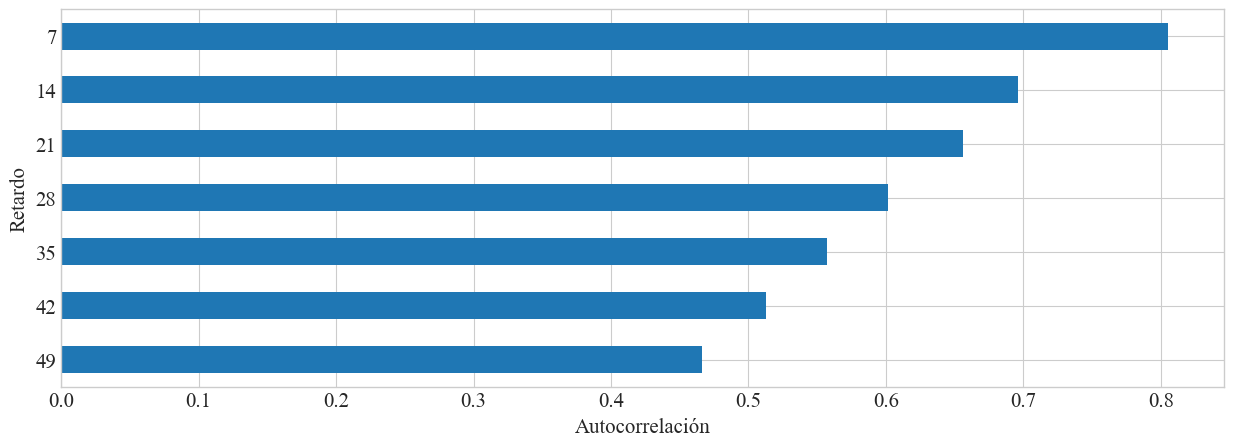

In [4]:
import statsmodels.api as sm

# Calculate autocorrelations

retardos = pd.DataFrame(sm.tsa.acf(dataset['Demand'], nlags=50))
retardos_semanales = retardos.query('index == [7, 14, 21, 28, 35, 42, 49]')

retardos_semanales.sort_values(by=0, ascending=True).plot(kind='barh', figsize=(15,5), legend=False)
plt.ylabel('Retardo')
plt.xlabel('Autocorrelación')
plt.show()

## Feature Engineering

En este enfoque, se extraen nuevas variables a partir de la marca temporal, empleándose estas para enriquecer el modelo.

In [26]:
import holidays
import datetime
from datetime import date

lst = []
es_holidays = holidays.ES()
start_date = date(2011, 1, 1)
end_date = date(2022, 12, 31)
delta = datetime.timedelta(days=1)

while start_date <= end_date:
    if start_date.strftime("%Y-%m-%d") in es_holidays:
        lst.append([start_date.strftime("%Y-%m-%d"), 1])
    else:
        lst.append([start_date.strftime("%Y-%m-%d"), 0])
    start_date += delta
df_holidays = pd.DataFrame(lst, columns=['Date', 'holiday'])
df_holidays['Date'] = pd.to_datetime(df_holidays['Date'])
df_holidays = df_holidays.set_index('Date')

dataset = dataset.merge(df_holidays, how='inner', on='Date')
dataset

,Temperature,Demand,Price,IBEX35,holiday
Date,,,,,
2011-01-01,9.6,605986.216,42.60,9928.25,1
2011-01-02,9.1,641856.087,42.73,9928.25,0
2011-01-03,6.5,801297.365,48.84,9922.05,0
2011-01-04,7.5,833253.263,45.67,9886.80,0
2011-01-05,10.0,803475.573,35.34,9740.85,0
...,...,...,...,...,...
2022-12-27,11.2,611568.630,107.66,8299.65,0
2022-12-28,10.3,629533.183,39.86,8285.85,0
2022-12-29,11.0,636823.461,16.24,8265.30,0


In [30]:
def create_features(df):
    """
    Create time series features based on time series index and
    applying continuous cyclic transformations (based on sine and cosine transformations)
    """
    
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week.astype('int64')
    
    cycle = 7
    
    df['weekdaysin'] = np.sin(2 * np.pi * df.index.dayofweek / cycle)
    df['weekdaycos'] = np.cos(2 * np.pi * df.index.dayofweek / cycle)
    return df

dataset.index = pd.to_datetime(dataset.index)
dataset = create_features(dataset)
dataset

,Temperature,Demand,Price,IBEX35,holiday,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekdaysin,weekdaycos
Date,,,,,,,,,,,,,,
2011-01-01,9.6,605986.216,42.60,9928.25,1,5,1,1,2011,1,1,52,-0.974928,-0.222521
2011-01-02,9.1,641856.087,42.73,9928.25,0,6,1,1,2011,2,2,52,-0.781831,0.623490
2011-01-03,6.5,801297.365,48.84,9922.05,0,0,1,1,2011,3,3,1,0.000000,1.000000
2011-01-04,7.5,833253.263,45.67,9886.80,0,1,1,1,2011,4,4,1,0.781831,0.623490
2011-01-05,10.0,803475.573,35.34,9740.85,0,2,1,1,2011,5,5,1,0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,11.2,611568.630,107.66,8299.65,0,1,4,12,2022,361,27,52,0.781831,0.623490
2022-12-28,10.3,629533.183,39.86,8285.85,0,2,4,12,2022,362,28,52,0.974928,-0.222521
2022-12-29,11.0,636823.461,16.24,8265.30,0,3,4,12,2022,363,29,52,0.433884,-0.900969


In [31]:
weekend = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 1}

dataset['weekend'] = dataset['dayofweek'].apply(lambda x: weekend[x])
dataset

,Temperature,Demand,Price,IBEX35,holiday,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekdaysin,weekdaycos,weekend
Date,,,,,,,,,,,,,,,
2011-01-01,9.6,605986.216,42.60,9928.25,1,5,1,1,2011,1,1,52,-0.974928,-0.222521,1
2011-01-02,9.1,641856.087,42.73,9928.25,0,6,1,1,2011,2,2,52,-0.781831,0.623490,1
2011-01-03,6.5,801297.365,48.84,9922.05,0,0,1,1,2011,3,3,1,0.000000,1.000000,0
2011-01-04,7.5,833253.263,45.67,9886.80,0,1,1,1,2011,4,4,1,0.781831,0.623490,0
2011-01-05,10.0,803475.573,35.34,9740.85,0,2,1,1,2011,5,5,1,0.974928,-0.222521,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,11.2,611568.630,107.66,8299.65,0,1,4,12,2022,361,27,52,0.781831,0.623490,0
2022-12-28,10.3,629533.183,39.86,8285.85,0,2,4,12,2022,362,28,52,0.974928,-0.222521,0
2022-12-29,11.0,636823.461,16.24,8265.30,0,3,4,12,2022,363,29,52,0.433884,-0.900969,0


In [32]:
# Create 1 week lag variable by shifting the target value for 7 days

dataset['lag_1week'] = dataset['Demand'].shift(7)
dataset

,Temperature,Demand,Price,IBEX35,holiday,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekdaysin,weekdaycos,weekend,lag_1week
Date,,,,,,,,,,,,,,,,
2011-01-01,9.6,605986.216,42.60,9928.25,1,5,1,1,2011,1,1,52,-0.974928,-0.222521,1,NaN
2011-01-02,9.1,641856.087,42.73,9928.25,0,6,1,1,2011,2,2,52,-0.781831,0.623490,1,NaN
2011-01-03,6.5,801297.365,48.84,9922.05,0,0,1,1,2011,3,3,1,0.000000,1.000000,0,NaN
2011-01-04,7.5,833253.263,45.67,9886.80,0,1,1,1,2011,4,4,1,0.781831,0.623490,0,NaN
2011-01-05,10.0,803475.573,35.34,9740.85,0,2,1,1,2011,5,5,1,0.974928,-0.222521,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,11.2,611568.630,107.66,8299.65,0,1,4,12,2022,361,27,52,0.781831,0.623490,0,723979.056
2022-12-28,10.3,629533.183,39.86,8285.85,0,2,4,12,2022,362,28,52,0.974928,-0.222521,0,710964.783
2022-12-29,11.0,636823.461,16.24,8265.30,0,3,4,12,2022,363,29,52,0.433884,-0.900969,0,694569.031


## Train / Test Split

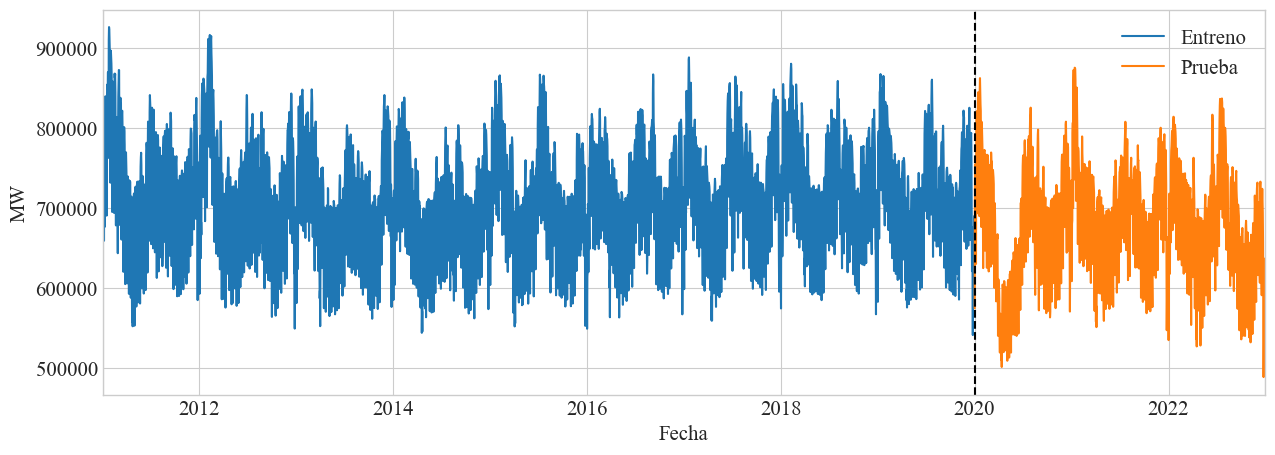

In [34]:
train = dataset.loc[dataset.index < '2020-01-01']
test = dataset.loc[dataset.index >= '2020-01-01']

fig, ax = plt.subplots(figsize=(15,5))
train['Demand'].plot(ax=ax, label='Training Set')
test['Demand'].plot(ax=ax, label='Test Set')
ax.axvline('2020-01-01', color='black', linestyle='dashed')
ax.legend(['Entreno', 'Prueba'])
plt.ylabel('MW')
plt.xlabel('Fecha')
plt.show()

## XGBoost

In [158]:
import xgboost as xgb

features = ['Temperature', 'Price', 'IBEX35', 'holiday',
            'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
            'dayofmonth', 'weekofyear', 'weekdaysin',
            'weekdaycos', 'weekend', 'lag_1week']

label = ['Demand']

X_train, y_train = train[features], train[label]

X_test, y_test = test[features], test[label]

reg_xgb = xgb.XGBRegressor(base_score=0.5,
                           booster='gbtree',
                           n_estimators=2000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01,
                           verbosity=0,
                           random_state=42)

reg_xgb.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=200)

[0]	validation_0-rmse:721393.04396	validation_1-rmse:687319.55924
[200]	validation_0-rmse:101051.47401	validation_1-rmse:83690.03030
[400]	validation_0-rmse:25810.32139	validation_1-rmse:34216.66613
[418]	validation_0-rmse:24512.89946	validation_1-rmse:34580.43608


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

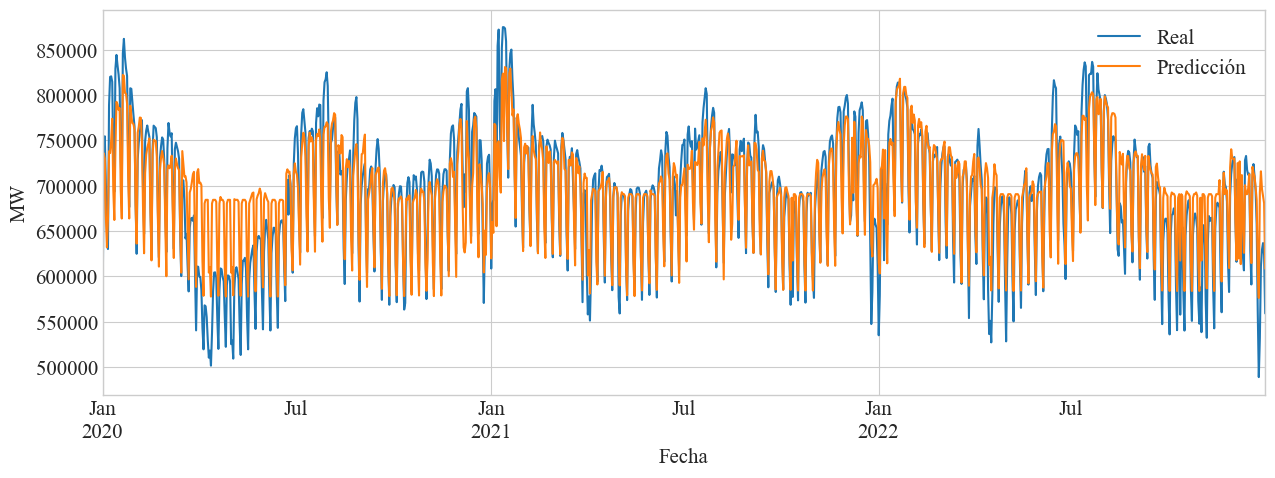

In [159]:
test['prediction_xgb'] = reg_xgb.predict(X_test)
dataset_prediction = dataset.merge(test[['prediction_xgb']], how='left', left_index=True, right_index=True)
dataset_prediction = dataset_prediction.query('~prediction_xgb.isna()')

ax = dataset_prediction[['Demand']].plot(figsize=(15,5))
dataset_prediction[['prediction_xgb']].plot(ax=ax)
ax.legend(['Real', 'Predicción'])
plt.ylabel('MW')
plt.xlabel('Fecha')
plt.show()

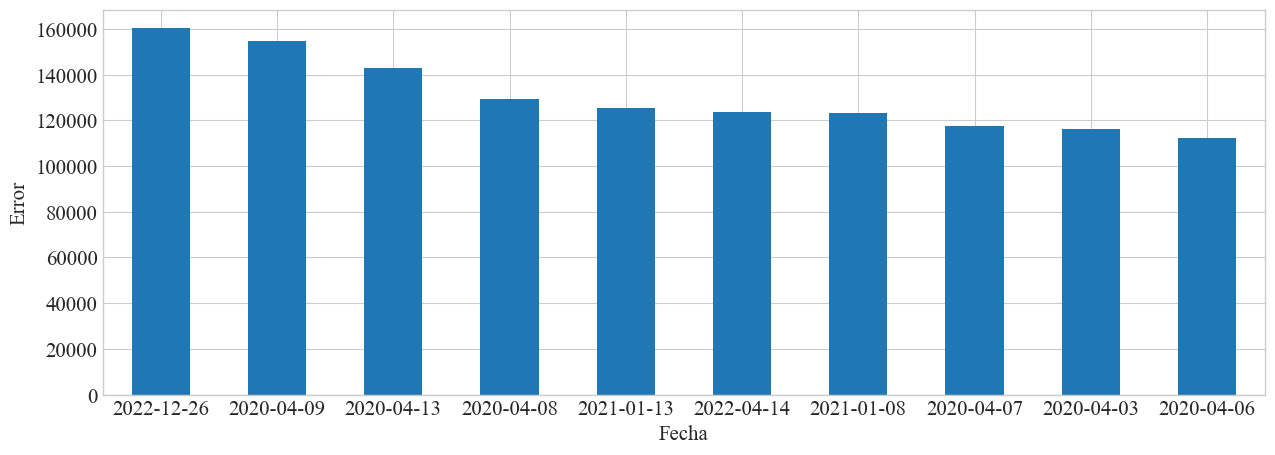

In [160]:
xgb_error = dataset_prediction[['Demand', 'prediction_xgb']]
xgb_error['error'] = np.abs(xgb_error['Demand'] - xgb_error['prediction_xgb'])
xgb_error['date'] = xgb_error.index.date
xgb_error.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(15,5))
plt.ylabel('Error')
plt.xlabel('Fecha')
plt.xticks(rotation=0)
plt.show()

In [161]:
rmse = np.sqrt(mean_squared_error(y_true=dataset_prediction['Demand'], y_pred=dataset_prediction['prediction_xgb']))
print('Test RMSE: {0:.2f}'.format(rmse))

mape = mean_absolute_percentage_error(y_true=dataset_prediction['Demand'], y_pred=dataset_prediction['prediction_xgb'])
print('Test MAPE: {0:.2f}'.format(mape * 100))

Test RMSE: 33812.82
Test MAPE: 3.69


## LightGBM

In [162]:
import lightgbm as lgb

features = ['Temperature', 'Price', 'IBEX35', 'holiday',
            'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
            'dayofmonth', 'weekofyear', 'weekdaysin',
            'weekdaycos', 'weekend', 'lag_1week']

label = ['Demand']

X_train, y_train = train[features], train[label]

X_test, y_test = test[features], test[label]

reg_lgb = lgb.LGBMRegressor(num_leaves=2,
                            boosting_type='gbdt',
                            n_estimators=2000,
                            early_stopping_rounds=50,
                            objective='regression',
                            learning_rate=0.01,
                            max_depth=3,
                            random_state=42)

reg_lgb.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=200)

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[200]	training's l2: 1.99681e+09	valid_1's l2: 2.9462e+09
[400]	training's l2: 1.37337e+09	valid_1's l2: 2.29463e+09
[600]	training's l2: 1.05306e+09	valid_1's l2: 1.95311e+09
[800]	training's l2: 8.60661e+08	valid_1's l2: 1.73055e+09
[1000]	training's l2: 7.42366e+08	valid_1's l2: 1.58186e+09
[1200]	training's l2: 6.6615e+08	valid_1's l2: 1.47476e+09
[1400]	training's l2: 6.15166e+08	valid_1's l2: 1.40129e+09
[1600]	training's l2: 5.79641e+08	valid_1's l2: 1.34493e+09
[1800]	training's l2: 5.54177e+08	valid_1's l2: 1.30492e+09
[2000]	training's l2: 5.34843e+08	valid_1's l2: 1.28436e+09


LGBMRegressor(early_stopping_rounds=50, learning_rate=0.01, max_depth=3,
              n_estimators=2000, num_leaves=2, objective='regression',
              random_state=42)

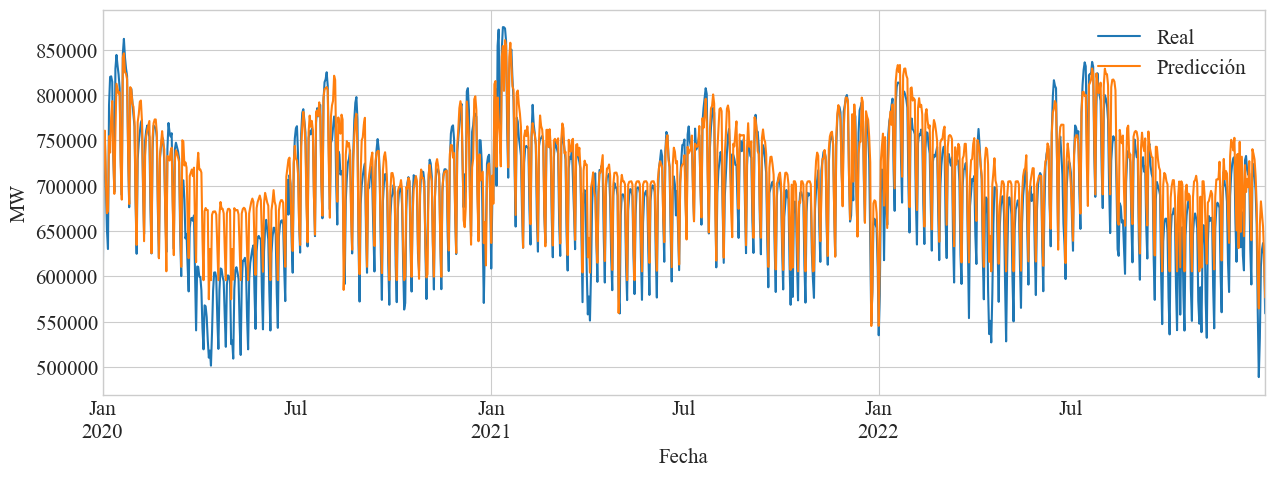

In [163]:
test['prediction_lgb'] = reg_lgb.predict(X_test)
dataset_prediction = dataset.merge(test[['prediction_lgb']], how='left', left_index=True, right_index=True)
dataset_prediction = dataset_prediction.query('~prediction_lgb.isna()')

ax = dataset_prediction[['Demand']].plot(figsize=(15,5))
dataset_prediction[['prediction_lgb']].plot(ax=ax)
ax.legend(['Real', 'Predicción'])
plt.ylabel('MW')
plt.xlabel('Fecha')
plt.show()

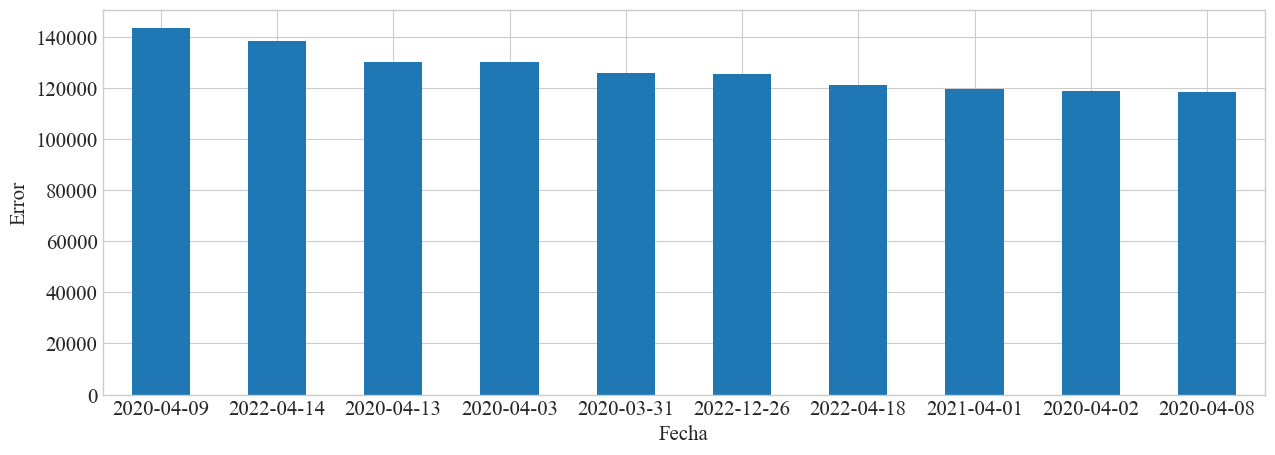

In [164]:
lgb_error = dataset_prediction[['Demand', 'prediction_lgb']]
lgb_error['error'] = np.abs(lgb_error['Demand'] - lgb_error['prediction_lgb'])
lgb_error['date'] = lgb_error.index.date
lgb_error.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(15,5))
plt.ylabel('Error')
plt.xlabel('Fecha')
plt.xticks(rotation=0)
plt.show()

In [165]:
rmse = np.sqrt(mean_squared_error(y_true=dataset_prediction['Demand'], y_pred=dataset_prediction['prediction_lgb']))
print('Test RMSE: {0:.2f}'.format(rmse))

mape = mean_absolute_percentage_error(y_true=dataset_prediction['Demand'], y_pred=dataset_prediction['prediction_lgb'])
print('Test MAPE: {0:.2f}'.format(mape * 100))

Test RMSE: 35837.93
Test MAPE: 4.13


## LSTM

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

tf.random.set_seed(42)

In [207]:
# Define dataset

df_input = dataset[['Demand', 'Temperature', 'Price', 'IBEX35']]
df_input

,Demand,Temperature,Price,IBEX35
Date,,,,
2011-01-01,605986.216,9.6,42.60,9928.25
2011-01-02,641856.087,9.1,42.73,9928.25
2011-01-03,801297.365,6.5,48.84,9922.05
2011-01-04,833253.263,7.5,45.67,9886.80
2011-01-05,803475.573,10.0,35.34,9740.85
...,...,...,...,...
2022-12-27,611568.630,11.2,107.66,8299.65
2022-12-28,629533.183,10.3,39.86,8285.85
2022-12-29,636823.461,11.0,16.24,8265.30


In [208]:
# Scaling data

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_input)
data_scaled

array([[0.26780285, 0.29818182, 0.0778139 , 0.67373352],
       [0.34991529, 0.28      , 0.07805136, 0.67373352],
       [0.71490438, 0.18545455, 0.089212  , 0.67266574],
       ...,
       [0.33839473, 0.34909091, 0.02966427, 0.3873365 ],
       [0.30814777, 0.42181818, 0.01077704, 0.38574344],
       [0.1608534 , 0.4       , 0.00476747, 0.38574344]])

In [209]:
# Train / Test Split

features = data_scaled
target = data_scaled[:,0]

x_train, y_train = features[:3287], target[:3287]
x_test, y_test = features[3287:], target[3287:]
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((3287, 4), (1096, 4), (3287,), (1096,))

In [210]:
# Define generator

win_length = 3
batch_size = 32
num_features = 4

train_generator = TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

In [211]:
# Define model

model_lstm = Sequential(name='model_lstm')
model_lstm.add(InputLayer(input_shape=(win_length, num_features), name='input'))
model_lstm.add(LSTM(128, return_sequences=True, name='lstm1'))
model_lstm.add(LeakyReLU(alpha=0.5))
model_lstm.add(LSTM(64, return_sequences=True, name='lstm2'))
model_lstm.add(LeakyReLU(alpha=0.5))
model_lstm.add(Dropout(.3))
model_lstm.add(LSTM(64, return_sequences=False, name='lstm3'))
model_lstm.add(Dropout(.3))
model_lstm.add(Dense(1, activation='linear', name='output'))

model_lstm.summary()

Model: "model_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm1 (LSTM)                (None, 3, 128)            68096     
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 3, 128)            0         
                                                                 
 lstm2 (LSTM)                (None, 3, 64)             49408     
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 3, 64)             0         
                                                                 
 dropout_12 (Dropout)        (None, 3, 64)             0         
                                                                 
 lstm3 (LSTM)                (None, 64)                33024     
                                                                 
 dropout_13 (Dropout)        (None, 64)                0

In [212]:
# Fit model

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3,
                               mode='min')

model_lstm.compile(loss=MeanSquaredError(),
                   optimizer=Adam(),
                   metrics=[RootMeanSquaredError()])

history = model_lstm.fit_generator(train_generator,
                                   epochs=50,
                                   validation_data=test_generator,
                                   shuffle=False,
                                   callbacks=[early_stopping])

Epoch 1/50
103/103 [==============================] - 9s 29ms/step - loss: 0.0657 - root_mean_squared_error: 0.2564 - val_loss: 0.0230 - val_root_mean_squared_error: 0.1515
Epoch 2/50
103/103 [==============================] - 1s 8ms/step - loss: 0.0288 - root_mean_squared_error: 0.1697 - val_loss: 0.0225 - val_root_mean_squared_error: 0.1498
Epoch 3/50
103/103 [==============================] - 1s 8ms/step - loss: 0.0279 - root_mean_squared_error: 0.1671 - val_loss: 0.0224 - val_root_mean_squared_error: 0.1495
Epoch 4/50
103/103 [==============================] - 1s 8ms/step - loss: 0.0268 - root_mean_squared_error: 0.1636 - val_loss: 0.0222 - val_root_mean_squared_error: 0.1491
Epoch 5/50
103/103 [==============================] - 1s 8ms/step - loss: 0.0261 - root_mean_squared_error: 0.1616 - val_loss: 0.0221 - val_root_mean_squared_error: 0.1487
Epoch 6/50
103/103 [==============================] - 1s 8ms/step - loss: 0.0256 - root_mean_squared_error: 0.1599 - val_loss: 0.0219 - val

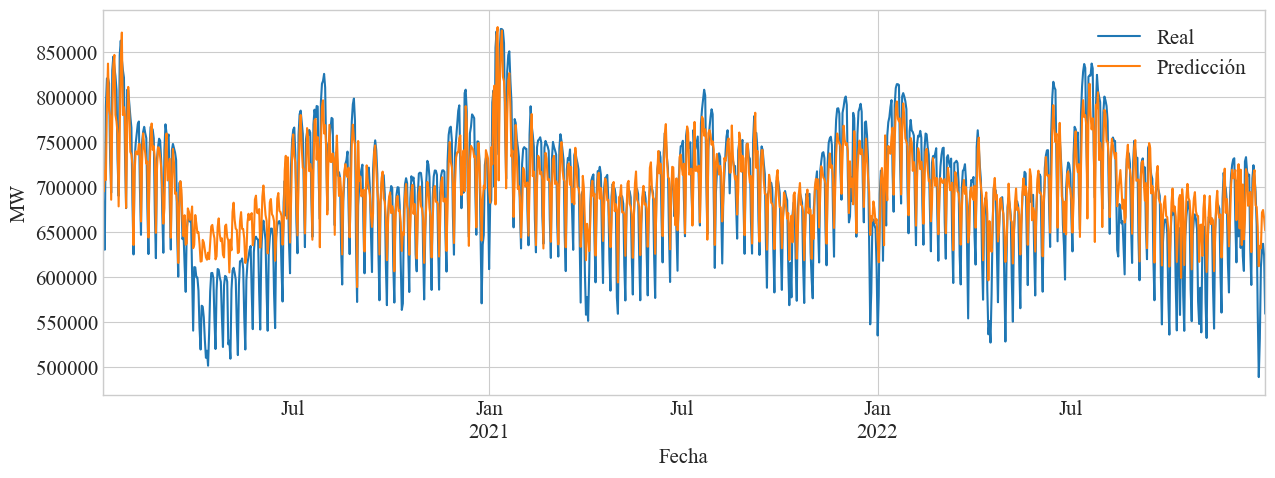

In [213]:
# Make predictions

predictions = model_lstm.predict_generator(test_generator)

df_pred = pd.concat([pd.DataFrame(predictions), pd.DataFrame(x_test[:,1:][win_length:])], axis=1)
rev_trans = scaler.inverse_transform(df_pred)
df_final = df_input[predictions.shape[0]*-1:]
df_final['Demand_Pred'] = rev_trans[:,0]

df_final[['Demand', 'Demand_Pred']].plot(figsize=(15,5))
plt.ylabel('MW')
plt.xlabel('Fecha')
plt.legend(['Real', 'Predicción'])
plt.show()

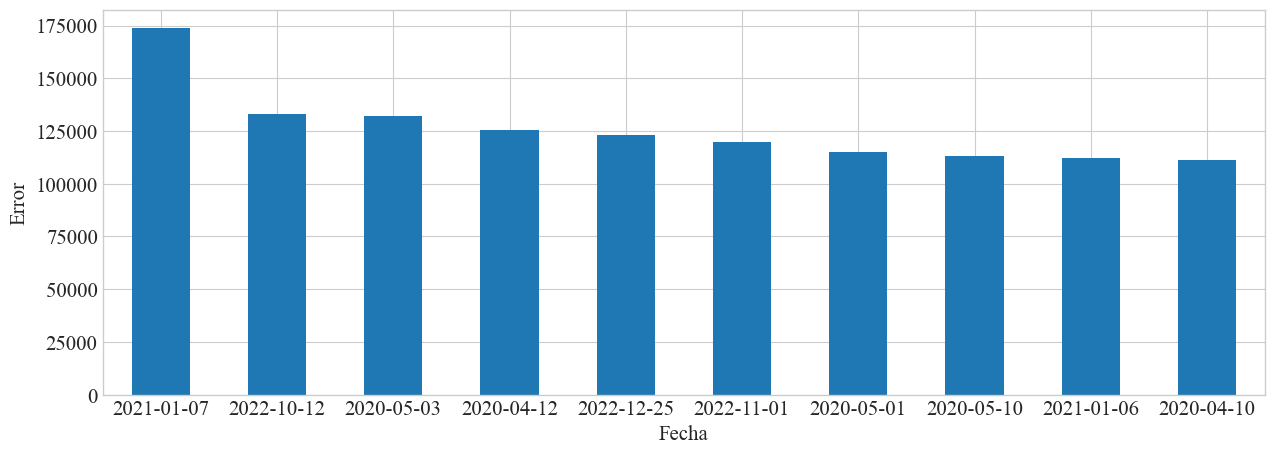

In [218]:
lstm_error = df_final[['Demand', 'Demand_Pred']]
lstm_error['error'] = np.abs(lstm_error['Demand'] - lstm_error['Demand_Pred'])
lstm_error['date'] = lstm_error.index.date
lstm_error.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(15,5))
plt.ylabel('Error')
plt.xlabel('Fecha')
plt.xticks(rotation=0)
plt.show()

In [219]:
rmse = np.sqrt(mean_squared_error(y_true=df_final['Demand'], y_pred=df_final['Demand_Pred']))
print('Test RMSE: {0:.2f}'.format(rmse))

mape = mean_absolute_percentage_error(y_true=df_final['Demand'], y_pred=df_final['Demand_Pred'])
print('Test MAPE: {0:.2f}'.format(mape * 100))

Test RMSE: 40284.60
Test MAPE: 4.85


In [220]:
all_predictions = xgb_error[['date', 'Demand', 'prediction_xgb']].join(lgb_error['prediction_lgb'])
all_predictions = all_predictions.join(lstm_error['Demand_Pred'])
all_predictions = all_predictions.rename(columns={'Demand_Pred': 'prediction_lstm'})
all_predictions

,date,Demand,prediction_xgb,prediction_lgb,prediction_lstm
Date,,,,,
2020-01-01,2020-01-01,574776.720,609427.6875,650093.400226,NaN
2020-01-02,2020-01-02,723522.375,735845.9375,752049.021483,NaN
2020-01-03,2020-01-03,754645.342,730032.7500,760829.767846,NaN
2020-01-04,2020-01-04,702390.878,666935.2500,707438.404139,782293.944788
2020-01-05,2020-01-05,651967.486,632101.6875,669768.272268,694877.486967
...,...,...,...,...,...
2022-12-27,2022-12-27,611568.630,716006.5625,682865.424991,631849.435480
2022-12-28,2022-12-28,629533.183,696308.5625,668748.156494,671507.593511
2022-12-29,2022-12-29,636823.461,688685.8750,654867.924503,674320.669994


In [221]:
all_predictions.to_csv('AllPredictions.csv', sep=';', decimal=',', index=False, header=True)
pd.read_csv(r'AllPredictions.csv', sep=';', decimal=',')

,date,Demand,prediction_xgb,prediction_lgb,prediction_lstm
0,2020-01-01,574776.720,609427.70,650093.400226,NaN
1,2020-01-02,723522.375,735845.94,752049.021483,NaN
2,2020-01-03,754645.342,730032.75,760829.767846,NaN
3,2020-01-04,702390.878,666935.25,707438.404139,782293.944788
4,2020-01-05,651967.486,632101.70,669768.272268,694877.486967
...,...,...,...,...,...
1091,2022-12-27,611568.630,716006.56,682865.424991,631849.435480
1092,2022-12-28,629533.183,696308.56,668748.156494,671507.593511
1093,2022-12-29,636823.461,688685.90,654867.924503,674320.669994
1094,2022-12-30,623610.426,680968.50,624187.049031,665546.336606
